In [10]:
import numpy as np
import pandas as pd
from backroom import *
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Structure the dataset
for cv_split in range(1,6):
    datasets = []
    train_df = pd.read_csv(f"../../data/interim/train_df_3_fold_{cv_split}.csv", index_col="id")
    val_df = pd.read_csv(f"../../data/interim/val_df_3_fold_{cv_split}.csv", index_col="id")
    test_df = pd.read_csv(f"../../data/interim/test_df_3_fold_{cv_split}.csv", index_col="id")
    datasets = [train_df, val_df, test_df]
    break


Train MAE 6.30814437156029
Val MAE 8.367092129317236
11.825751005528739
11.3575089706186


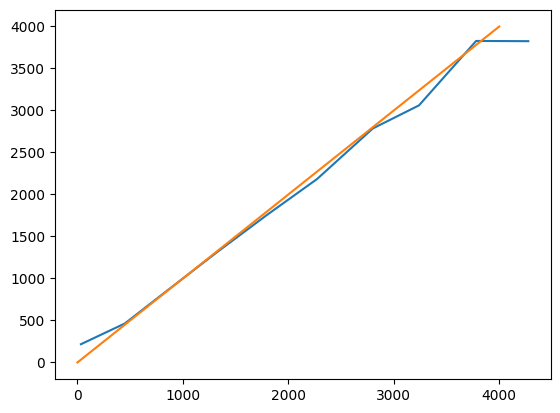

In [79]:
import xgboost as xgb
model = xgb.XGBRegressor(
    random_state=42,
    monotone_constraints=(0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1),
)

features = ['VendorID', 'passenger_count', 'payment_type_1', 'dual_location_risk_score', 'PULocationID_risk_score', 'DOLocationID_risk_score', 'pickup_day_of_week_risk_score', 'VendorID_risk_score', 'passenger_count_risk_score', 'payment_type_1_risk_score', 'hour_risk_score', 'closest_hour_risk_score', 'closest_hour_and_a_half_risk_score', 'dayofweek_plus_hour_risk_score', 'dayofweek_plus_closest_hour_risk_score', 'dayofweek_plus_closest_hour_and_a_half_risk_score']
X_train = train_df[features]
X_val = val_df[features]


model.fit(X_train, train_df['duration_seconds'])

predict_train = model.predict(X_train)
predict_val = model.predict(X_val)


mse = mean_squared_error(train_df['duration_seconds'], predict_train)
train_df['prediction_duration_seconds'] = predict_train
print("Train MAE", np.sqrt(mse)/60)
mse = mean_squared_error(val_df['duration_seconds'], predict_val)
val_df['prediction_duration_seconds'] = predict_val
print("Val MAE", np.sqrt(mse)/60)


# Baselines
mse = mean_squared_error(train_df['duration_seconds'], [train_df['duration_seconds'].median()]*train_df.shape[0])
print(np.sqrt(mse)/60)
mse = mean_squared_error(train_df['duration_seconds'], [train_df['duration_seconds'].mean()]*train_df.shape[0])
print(np.sqrt(mse)/60)

def print_calibration_plot(dataset):
    xs = []
    ys = []
    num_bins = 10
    bins = np.linspace(np.min(dataset['prediction_duration_seconds']), np.max(dataset['prediction_duration_seconds']), num_bins + 1)
    avg_pred = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (dataset['prediction_duration_seconds'] >= bins[i]) & (dataset['prediction_duration_seconds'] < bins[i + 1])
        temp = dataset[mask].copy()
        ys.append(temp.duration_seconds.mean())
        xs.append(temp.prediction_duration_seconds.mean())
    plt.plot(xs, ys)
    plt.plot([0, 4000], [0, 4000])
print_calibration_plot(train_df)


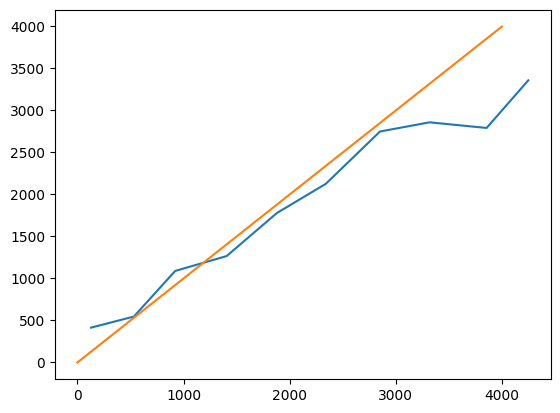

In [80]:
print_calibration_plot(val_df)

In [81]:
# Also tried random forest and it did slightly better on the validation set, but calibratoin didn't look quite as good
